# Введение в искусственные нейронные сети
# Урок 5. Рекуррентные нейронные сети

#### 1) Попробуйте изменить параметры нейронной сети, работающей с датасетом imdb, либо нейронной сети, работающей airline-passengers (она прилагается вместе с датасетом к уроку в виде отдельного скрипта) так, чтобы улучшить её точность. Приложите анализ


In [1]:
from __future__ import print_function

import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.utils as ku 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import  SimpleRNN, LSTM, GRU, Flatten,  Conv1D, Conv2D,  Dropout, Bidirectional
from keras.datasets import imdb

imdb загружает набор данных IMDB.

Набор данных состоит из 25 000 рецензий к фильмам от IMDB и имеет положительные или отрицательные метки. Рецензии были предварительно обработаны, и каждая рецензия кодируется как список индексов слов (целых чисел). Для удобства слова индексируются по общей частоте в наборе данных, так что, например, целое число "3" кодирует 3-е наиболее частое слово в данных. Это позволяет выполнять быстрые операции фильтрации.

Как правило, "0" означает не конкретное слово, а используется для кодирования любого неизвестного слова.

In [2]:
max_features = 10000

# Каждый отзыв(рецензия) имеею разную длину уникальных слов, поэтому необходимо обрезать отзыв и сделать векторы равной длины.
# Нейронка принимает только равные по длине векторы!
# обрезание текстов после данного количества слов (среди top max_features наиболее используемые слова)
maxlen = 80
batch_size = 50 # увеличьте значение для ускорения обучения

print('Загрузка данных...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'тренировочные последовательности')
print(len(x_test), 'тестовые последовательности')

Загрузка данных...
25000 тренировочные последовательности
25000 тестовые последовательности


In [3]:
index = imdb.get_word_index()
len(index)

88584

Text(0, 0.5, 'N_reviews < maxlen')

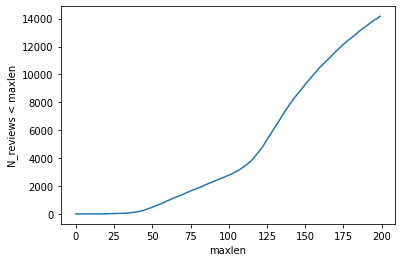

In [4]:
# Проверим сколько отзывов имеют длину меньше заданной длины maxlen
list_loss_len = []
for num_ in range(200):
    less_then_maxlen = [ii for ii in range(len(x_train)) if (len(x_train[ii]) < num_ )]
    list_loss_len.append(len(less_then_maxlen))

plt.plot(range(len(list_loss_len)), list_loss_len)
plt.xlabel('maxlen')
plt.ylabel('N_reviews < maxlen')

In [5]:
print('Pad последовательности (примеров в x единицу времени)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad последовательности (примеров в x единицу времени)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


In [6]:
len(x_train[6719])

80

In [7]:
x_train[6719]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    1,   13,  586,  851,   14,   31,   60,   23,
       2863, 2364,  314])

In [8]:
def vectorize_seq(data, xLen = 100, step = 1):
    results = np.zeros((len(data), xLen, 1))
    for i, sequence in enumerate(data):
        for j in range(xLen):
            results[i, j, :] = sequence[j]           
    return results
 
data_train_seq = vectorize_seq(x_train, xLen = 80)
data_test_seq = vectorize_seq(x_test, xLen = 80)

In [9]:
data_train_seq[0,:,0]

array([1.500e+01, 2.560e+02, 4.000e+00, 2.000e+00, 7.000e+00, 3.766e+03,
       5.000e+00, 7.230e+02, 3.600e+01, 7.100e+01, 4.300e+01, 5.300e+02,
       4.760e+02, 2.600e+01, 4.000e+02, 3.170e+02, 4.600e+01, 7.000e+00,
       4.000e+00, 2.000e+00, 1.029e+03, 1.300e+01, 1.040e+02, 8.800e+01,
       4.000e+00, 3.810e+02, 1.500e+01, 2.970e+02, 9.800e+01, 3.200e+01,
       2.071e+03, 5.600e+01, 2.600e+01, 1.410e+02, 6.000e+00, 1.940e+02,
       7.486e+03, 1.800e+01, 4.000e+00, 2.260e+02, 2.200e+01, 2.100e+01,
       1.340e+02, 4.760e+02, 2.600e+01, 4.800e+02, 5.000e+00, 1.440e+02,
       3.000e+01, 5.535e+03, 1.800e+01, 5.100e+01, 3.600e+01, 2.800e+01,
       2.240e+02, 9.200e+01, 2.500e+01, 1.040e+02, 4.000e+00, 2.260e+02,
       6.500e+01, 1.600e+01, 3.800e+01, 1.334e+03, 8.800e+01, 1.200e+01,
       1.600e+01, 2.830e+02, 5.000e+00, 1.600e+01, 4.472e+03, 1.130e+02,
       1.030e+02, 3.200e+01, 1.500e+01, 1.600e+01, 5.345e+03, 1.900e+01,
       1.780e+02, 3.200e+01])

In [10]:
#простая модель

print('Построение модели...')
model = Sequential()
model.add(LSTM(128,return_sequences = False,input_shape = ( 80,1)))
model.add(Dense(1, activation = 'sigmoid'))

# стоит попробовать использовать другие оптимайзер и другие конфигурации оптимайзеров 
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

print('Процесс обучения...')
model.fit(data_train_seq, y_train,
          batch_size = 100,
          epochs = 1, # увеличьте при необходимости
          validation_data = (data_test_seq, y_test))

score, acc = model.evaluate(data_test_seq, y_test,
#                             batch_size = batch_size
                           )
print('Результат при тестировании:', score)
print('Тестовая точность:', acc)

Построение модели...
Процесс обучения...
782/782 [==============================] - 14s 18ms/step - loss: 0.6877 - accuracy: 0.5409
Результат при тестировании: 0.6877272129058838
Тестовая точность: 0.5409200191497803


In [36]:
#сложнее модель

print('Построение модели...')
model = Sequential()

model.add(Embedding( max_features,16))
# model.add(LSTM(8, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))

# при переходе к полносвязному слою "return_sequences = True" необходимо отключать!
model.add(LSTM(16, dropout = 0.1, recurrent_dropout = 0.3))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

print('Процесс обучения...')
model.fit(data_train_seq, y_train,
          batch_size = 30,
          epochs = 1, # увеличьте при необходимости
          validation_data = (data_test_seq, y_test))

score, acc = model.evaluate(data_test_seq, y_test,
#                             batch_size = batch_size
                           )
print('Результат при тестировании:', score)
print('Тестовая точность:', acc)

Построение модели...
Процесс обучения...
782/782 [==============================] - 5s 6ms/step - loss: 0.3595 - accuracy: 0.8404
Результат при тестировании: 0.35953739285469055
Тестовая точность: 0.8404399752616882


Понижение размера батча(пакет размером 20 - 50) немного увеличивает метрику. Подбор более оптимального dropout также немного увеличивает метрику.

Подбор оптимайзера в данном случае практически не влияет на метрику в лучшую сторону(лучший результат с оптимайзером Adam), увеличение количества нейронов > 128 также практически не прибавляет качества(и увеличивает время работы). Использование слоя GRU(или слоёв только на GRU) не приводит к улучшению метрики. Увеличение колчества LSTM слоев не приводит к улучшению качества, как и количества полносвязных слоев.

Использование SimpleRNN значительно ухудшает метрику. Использование activation = 'linear' в выходном слое ухудшает метрику.


##### 2) Попробуйте изменить параметры нейронной сети, генерирующей текст таким образом, чтобы добиться генерации как можно более осмысленного текста. Пришлите лучший текст из получившихся и опишите предпринятые для его получения действия. Можно использовать текст другого произведения

In [37]:
tokenizer = Tokenizer(num_words=10000)

data = open('alice_in_wonderland.txt', encoding="utf-8").read()
#Читаем текст
corpus = data.lower().split("\n")

In [49]:
corpus[:50]

['project gutenberg’s alice’s adventures in wonderland, by lewis carroll',
 '',
 'this ebook is for the use of anyone anywhere at no cost and with',
 'almost no restrictions whatsoever.  you may copy it, give it away or',
 're-use it under the terms of the project gutenberg license included',
 'with this ebook or online at www.gutenberg.org',
 '',
 '',
 'title: alice’s adventures in wonderland',
 '',
 'author: lewis carroll',
 '',
 'posting date: june 25, 2008 [ebook #11]',
 'release date: march, 1994',
 'last updated: october 6, 2016',
 '',
 'language: english',
 '',
 'character set encoding: utf-8',
 '',
 '*** start of this project gutenberg ebook alice’s adventures in wonderland ***',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'alice’s adventures in wonderland',
 '',
 'lewis carroll',
 '',
 'the millennium fulcrum edition 3.0',
 '',
 '',
 '',
 '',
 'chapter i. down the rabbit-hole',
 '',
 'alice was beginning to get very tired of sitting by her sister on the',
 'bank, and of

In [39]:
tokenizer.fit_on_texts( corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [40]:
tokenizer.word_index['posting']

1840

In [41]:
label.shape

(28231, 3399)

In [42]:
callback = EarlyStopping( monitor = 'val_accuracy', patience = 10) # создаем обратный вызов - calback - тут "Ранняя остановка"

In [43]:
model = Sequential()
model.add(Embedding(total_words, 256, input_length = max_sequence_len-1)) 
# вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), 
#   на выход строим вектор из n (тут 256) координат - он плотный
model.add(Bidirectional(LSTM(50, return_sequences = True)))

model.add(LSTM(32, dropout = 0.1, recurrent_dropout = 0.3))
# model.add(Dropout( 0.2))
model.add(Dense(total_words/2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
model.add(Dense(total_words, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 17, 256)           870144    
                                                                 
 bidirectional (Bidirectiona  (None, 17, 100)          122800    
 l)                                                              
                                                                 
 lstm_37 (LSTM)              (None, 32)                17024     
                                                                 
 dense_31 (Dense)            (None, 1699)              56067     
                                                                 
 dense_32 (Dense)            (None, 3399)              5778300   
                                                                 
Total params: 6,844,335
Trainable params: 6,844,335
Non-trainable params: 0
___________________________________________

In [44]:
# перезапустить, не дожидаясь конца
history = model.fit(predictors, label, epochs=25, validation_split=0.2, callbacks=[callback],verbose=1)

Epoch 1/25
706/706 [==============================] - 64s 83ms/step - loss: 6.1936 - accuracy: 0.0562 - val_loss: 7.0019 - val_accuracy: 0.0519
Epoch 2/25
706/706 [==============================] - 57s 81ms/step - loss: 5.7172 - accuracy: 0.0718 - val_loss: 7.1703 - val_accuracy: 0.0781
Epoch 3/25
706/706 [==============================] - 56s 79ms/step - loss: 5.4770 - accuracy: 0.0936 - val_loss: 7.3011 - val_accuracy: 0.0820
Epoch 4/25
706/706 [==============================] - 56s 79ms/step - loss: 5.2824 - accuracy: 0.1063 - val_loss: 7.5345 - val_accuracy: 0.0912
Epoch 5/25
706/706 [==============================] - 56s 80ms/step - loss: 5.1230 - accuracy: 0.1176 - val_loss: 7.5225 - val_accuracy: 0.0978
Epoch 6/25
706/706 [==============================] - 56s 79ms/step - loss: 4.9759 - accuracy: 0.1336 - val_loss: 7.8231 - val_accuracy: 0.0942
Epoch 7/25
706/706 [==============================] - 56s 79ms/step - loss: 4.8422 - accuracy: 0.1463 - val_loss: 7.9381 - val_accuracy:

In [65]:
# начальная строка
# seed_text = "alice opened the door and"
seed_text = "Alice was considering in her own mind"

next_words = 8
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    print(token_list)
    token_list = pad_sequences([token_list], maxlen = max_sequence_len-1, padding='pre')
  #predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    y_p = model.predict(token_list)
    y_predict = y_p * np.random.random(  size = (1,y_p.shape[1]))
    predicted_ind = np.argmax(y_predict,axis = 1)
    
    for word, index in tokenizer.word_index.items():
        if index == predicted_ind:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

[12, 13, 1018, 10, 17, 409, 377]
[12, 13, 1018, 10, 17, 409, 377, 19]
[12, 13, 1018, 10, 17, 409, 377, 19, 72]
[12, 13, 1018, 10, 17, 409, 377, 19, 72, 163]
[12, 13, 1018, 10, 17, 409, 377, 19, 72, 163, 16]
[12, 13, 1018, 10, 17, 409, 377, 19, 72, 163, 16, 7]
[12, 13, 1018, 10, 17, 409, 377, 19, 72, 163, 16, 7, 13]
[12, 13, 1018, 10, 17, 409, 377, 19, 72, 163, 16, 7, 13, 29]
Alice was considering in her own mind at its eyes as she was very earnestly


Алиса мысленно рассматривала его глаза, так как она была очень серьезна

Чем длинее выстраивается фраза, тем менее она адекватна(т.е. алгоритм выдает что-то несуразное). Более-менее "осмысленно" выстраиваются средние фразы (до 20 слов), хотя получить от данного алгоритма что-то хорошо выстроенное очень непросто - пока в данном случае единственным вариантом является выстраивание фразы по частям(когда алгоритм выдал что-то вменяемое, а затем к этому добавлять следующее, при этом прийдется вручную определять адекватность куска фразы).